# Inflow analysis

Try to find correlation between rainfall and water inflow in the the pipe.

In [48]:
import datetime
import calendar
import json
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4

# Load project

In [3]:
project_folder = '../../datasets/thorium-medium/'
with open(project_folder + 'project.json', 'r') as file:
    project = json.load(file)
print(json.dumps(project, indent=4))
flow = pd.read_csv(project_folder + 'flow1.csv', parse_dates=['time'])
flow = flow.set_index('time')['flow'].fillna(0)
flow = flow.resample('5T').pad()
rainfall = pd.read_csv(project_folder + 'rainfall1.csv', parse_dates=['time'])
rainfall = rainfall.set_index('time')['rainfall'].fillna(0)
rainfall = rainfall.resample('5T').pad()
flow_rain = pd.concat([flow, rainfall], axis=1).dropna()
print(flow_rain.head())
print(flow_rain.tail())

{
    "split-date": "2017-01-01",
    "rainfalls": [
        "rainfall1"
    ],
    "start-date": "2015-06-02",
    "name": "thorium-medium",
    "end-date": "2017-10-01",
    "flows": [
        "flow1"
    ]
}
                           flow  rainfall
time                                     
2015-06-01 14:15:00  115.559998       0.0
2015-06-01 14:20:00  115.199997       0.0
2015-06-01 14:25:00  112.209999       0.0
2015-06-01 14:30:00  112.860001       0.0
2015-06-01 14:35:00  113.349998       0.0
                           flow  rainfall
time                                     
2017-11-10 14:20:00  107.830002       0.0
2017-11-10 14:25:00  107.459999       0.0
2017-11-10 14:30:00  106.919998       0.0
2017-11-10 14:35:00  105.559998       0.0
2017-11-10 14:40:00  104.940002       0.0


Add column for different rolling windon operation on rainfall data. This will help to find dry weather patterns and also we will use it to try to find correlation betwee nrainfall intensity and eccessive flow.

In [32]:
flow_rain['precipitation_1h'] = flow_rain.rainfall.rolling(12).sum()
flow_rain['precipitation_2h'] = flow_rain.rainfall.rolling(2*12).sum()
flow_rain['precipitation_4h'] = flow_rain.rainfall.rolling(4*12).sum()
flow_rain['precipitation_8h'] = flow_rain.rainfall.rolling(8*12).sum()
flow_rain[pd.Timestamp('2017-05-01'):pd.Timestamp('2017-05-02')].head(10)

,flow,rainfall,precipitation_1h,precipitation_2h,precipitation_4h,precipitation_8h,inflow
time,,,,,,,
2017-05-01 00:00:00,128.320007,0.000,0.254,2.540,11.938,12.954,NaN
2017-05-01 00:05:00,126.919998,1.016,1.270,3.048,12.954,13.970,NaN
2017-05-01 00:10:00,124.800003,0.254,1.524,2.794,13.208,14.224,NaN
2017-05-01 00:15:00,123.400002,0.000,1.524,2.286,13.208,14.224,NaN
2017-05-01 00:20:00,121.580002,0.000,1.524,2.032,13.208,14.224,NaN
2017-05-01 00:25:00,120.430000,0.000,1.524,1.778,13.208,14.224,NaN
2017-05-01 00:30:00,120.000000,0.254,1.778,2.032,13.462,14.478,NaN
2017-05-01 00:35:00,118.320000,0.000,1.778,2.032,13.462,14.478,NaN
2017-05-01 00:40:00,117.730003,0.000,1.778,1.778,13.462,14.478,NaN


## Find Dry Weather Pattern

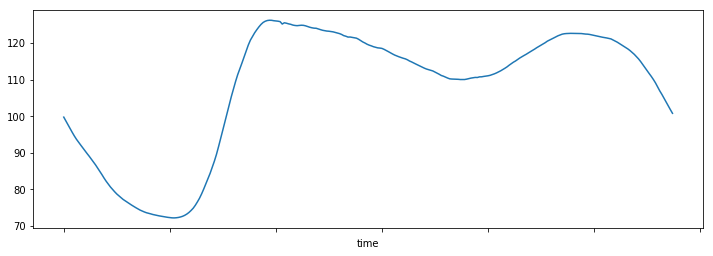

In [18]:
df = flow_rain[flow_rain.precipitation_8h < 0.1].reset_index()
daily_pattern = df.groupby(by=[df.time.map(lambda x : (x.hour, x.minute))]).flow.mean()
daily_pattern.plot()
plt.show()

## Add inflow data based on daily pattern

In [39]:
def inflow(row):
    pattern_idx = (row.name.hour, row.name.minute)
    pattern_value = daily_pattern[pattern_idx]
    return row.flow - pattern_value


flow_rain['inflow'] = flow_rain.apply(inflow, axis=1)
flow_rain.tail()

,flow,rainfall,precipitation_1h,precipitation_2h,precipitation_4h,precipitation_8h,inflow
time,,,,,,,
2017-11-10 14:20:00,107.830002,0.0,-9.325873e-15,-3.930190e-14,-3.019807e-14,9.769963e-14,-4.900445
2017-11-10 14:25:00,107.459999,0.0,-9.325873e-15,-3.930190e-14,-3.019807e-14,9.769963e-14,-5.079138
2017-11-10 14:30:00,106.919998,0.0,-9.325873e-15,-3.930190e-14,-3.019807e-14,9.769963e-14,-5.460512
2017-11-10 14:35:00,105.559998,0.0,-9.325873e-15,-3.930190e-14,-3.019807e-14,9.769963e-14,-6.519046
2017-11-10 14:40:00,104.940002,0.0,-9.325873e-15,-3.930190e-14,-3.019807e-14,9.769963e-14,-6.870444


# Check rainfall - inflow correlation

## Check 1 hour precipitation correlation

y = 4.269x + -1.845


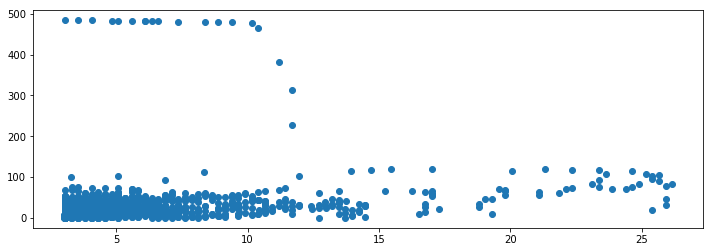

In [75]:
df = flow_rain[(flow_rain.precipitation_1h > 3) & (flow_rain.inflow < 2000) & (flow_rain.inflow > 0)]
slope, intercept, r_value, p_value, std_err = stats.linregress(df.precipitation_1h, df.inflow)
print('y = {:.4}x + {:.4}'.format(slope, intercept))
plt.scatter(df.precipitation_1h, df.inflow)
plt.show()

## Check 2 hours precipitation correlation

y = 3.277x + -8.635


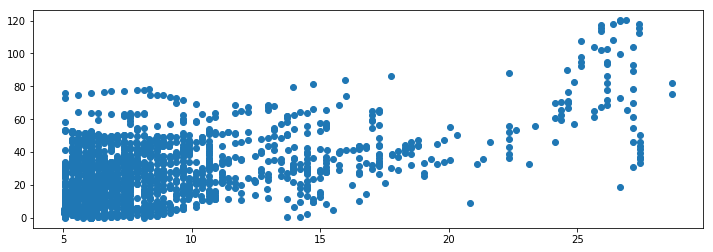

In [68]:
df = flow_rain[(flow_rain.precipitation_2h > 5) & (flow_rain.inflow < 200) & (flow_rain.inflow > 0)]
slope, intercept, r_value, p_value, std_err = stats.linregress(df.precipitation_2h, df.inflow)
print('y = {:.4}x + {:.4}'.format(slope, intercept))
plt.scatter(df.precipitation_2h, df.inflow)
plt.show()

## Check 4 hours precipitation correlation

y = 0.7837x + 4.13


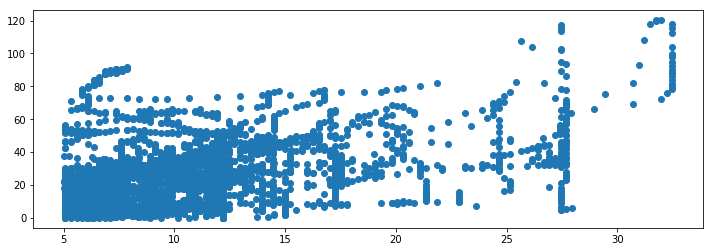

In [57]:
df = flow_rain[(flow_rain.precipitation_4h > 5) & (flow_rain.inflow < 150) & (flow_rain.inflow > 0)]
slope, intercept, r_value, p_value, std_err = stats.linregress(df.precipitation_4h, df.inflow)
print('y = {:.4}x + {:.4}'.format(slope, intercept))
plt.scatter(df.precipitation_4h, df.inflow)
plt.show()

## Check 8 hours precipitation correlation

y = -0.3438x + 21.65


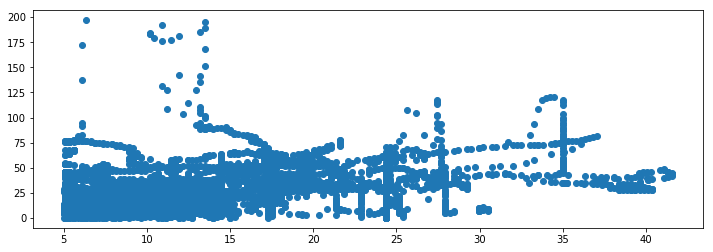

In [58]:
df = flow_rain[(flow_rain.precipitation_8h > 5) & (flow_rain.inflow < 200) & (flow_rain.inflow > 0)]
slope, intercept, r_value, p_value, std_err = stats.linregress(df.precipitation_8h, df.inflow)
print('y = {:.4}x + {:.4}'.format(slope, intercept))
plt.scatter(df.precipitation_8h, df.inflow)
plt.show()

# Analysis of days with very high inflow

In [89]:
set(flow_rain[flow_rain.inflow > 300].index.date)

{datetime.date(2017, 5, 5), datetime.date(2017, 5, 25)}

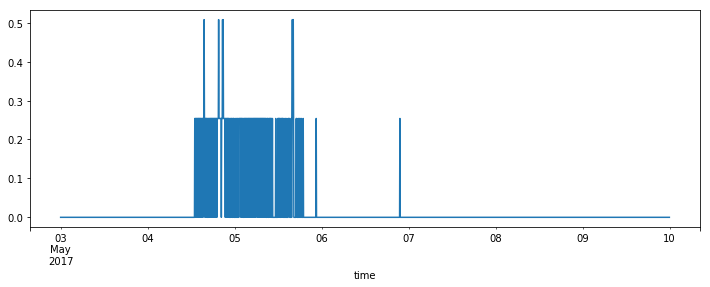

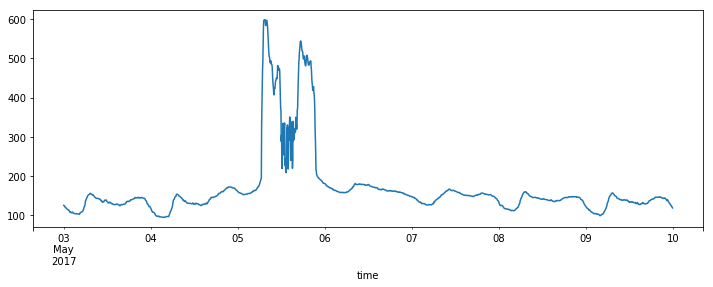

In [95]:
df = flow_rain['2017-05-03': '2017-05-09']
df.rainfall.plot()
plt.show()
df.flow.plot()
plt.show()

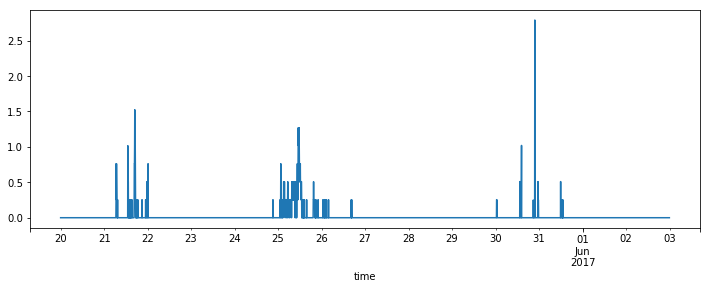

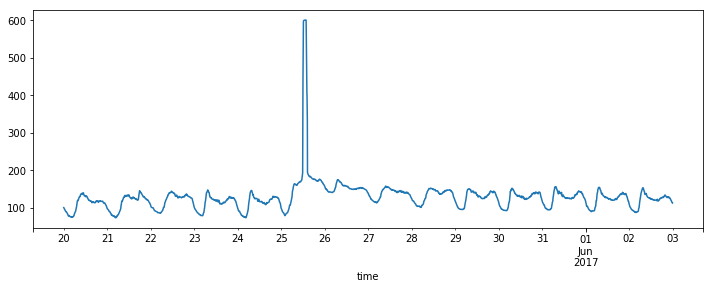

In [97]:
df = flow_rain['2017-05-20': '2017-06-02']
df.rainfall.plot()
plt.show()
df.flow.plot()
plt.show()